In [212]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import itertools as itr
import copy
from boundaries import WallBoundary, PressureBoundary, VelocityBoundary
from generators import WallGenerators
from simulation import Simulation
import pandas as pd
import random

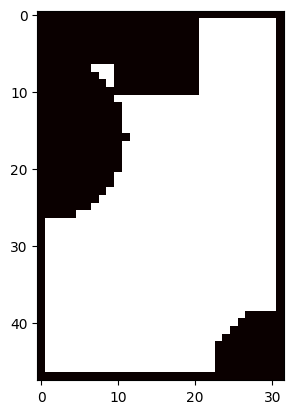

In [213]:
yResolution = 48
xResolution = 32
ACspeed = 1

walls = WallBoundary(yResolution, xResolution)
walls.borderWall()
conditions = walls.generateRoom()
walls.generateIndex()
walls.generateACDirections()
walls.indexPossibleACPos()

plt.imshow(walls.invertedBoundary, cmap="hot", interpolation="nearest")
#plt.savefig(f'data/images/{count}.png')

In [214]:
main = pd.DataFrame()
count = 0

Total Number Of Cobinations: 136
[(2, 21), (3, 21), (4, 21), (5, 21), (6, 21), (7, 21), (8, 21), (9, 21), (10, 21), (11, 20), (11, 19), (11, 18), (11, 17), (11, 16), (11, 15), (11, 14), (11, 13), (11, 12), (11, 11), (12, 11), (13, 11), (14, 11), (15, 11), (16, 12), (17, 11), (18, 11), (19, 11), (20, 11), (21, 10), (22, 10), (23, 9), (24, 8), (25, 7), (26, 6), (26, 5), (27, 4), (27, 3), (27, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (46, 2), (46, 3), (46, 4), (46, 5), (46, 6), (46, 7), (46, 8), (46, 9), (46, 10), (46, 11), (46, 12), (46, 13), (46, 14), (46, 15), (46, 16), (46, 17), (46, 18), (46, 19), (46, 20), (46, 21), (46, 22), (45, 22), (44, 22), (43, 22), (42, 23), (41, 24), (40, 25), (39, 26), (38, 27), (38, 28), (38, 29), (38, 30), (37, 30), (36, 30), (35, 30), (34, 30), (33, 30), (32, 30), (31, 30), (30, 30), (29, 30), (28, 30), (27, 30), 

c:\Users\LENOVO\Documents\GitHub\AIBuilder-LatticeBoltzmann\simulation.py:52: RuntimeWarning: invalid value encountered in divide
  self.speedY = self.momentumY / self.density
c:\Users\LENOVO\Documents\GitHub\AIBuilder-LatticeBoltzmann\simulation.py:53: RuntimeWarning: invalid value encountered in divide
  self.speedX = self.momentumX / self.density
c:\Users\LENOVO\Documents\GitHub\AIBuilder-LatticeBoltzmann\simulation.py:71: RuntimeWarning: invalid value encountered in divide
  self.speedY = self.momentumY / self.density
c:\Users\LENOVO\Documents\GitHub\AIBuilder-LatticeBoltzmann\simulation.py:72: RuntimeWarning: invalid value encountered in divide
  self.speedX = self.momentumX / self.density


Done!
It works! Momentum: 6.793350297476747


Trying direction: [-1  0]...
Works! Testing now...
Done!


Trying direction: [ 0 -1]...
Doesn't work! Moving on...


Trying direction: [1 1]...
Works! Testing now...
Done!


Trying direction: [-1  1]...
Works! Testing now...
Done!
It exploded :() or didn't equalize
--------------
Simulation batch 2/136
Trying direction: [1 0]...
Works! Testing now...
Done!


Trying direction: [0 1]...
Works! Testing now...
Done!
It works! Momentum: 7.14313573267476


Trying direction: [-1  0]...
Works! Testing now...
Done!


Trying direction: [ 0 -1]...
Doesn't work! Moving on...


Trying direction: [1 1]...
Works! Testing now...
Done!


Trying direction: [-1  1]...
Works! Testing now...
Done!
It exploded :() or didn't equalize
--------------
Simulation batch 3/136
Trying direction: [1 0]...
Works! Testing now...
Done!


Trying direction: [0 1]...
Works! Testing now...
Done!
It works! Momentum: 7.422716617497674


Trying direction: [-1  0]...
Works! Testing

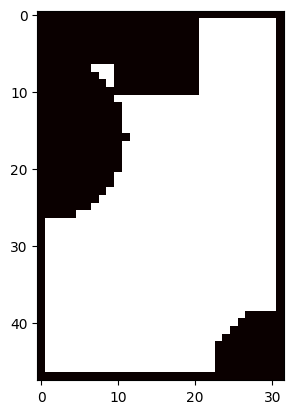

In [215]:

bestPos = []
bestDirection = []
bestTemp = 0

total = len([i for i in walls.possibleACIndex])
print(f"Total Number Of Cobinations: {total}")
start = 1
print(walls.possibleACIndex)

plt.imshow(walls.invertedBoundary, cmap="hot", interpolation="nearest")

for index, pos in enumerate(walls.possibleACIndex):
    print(f"Simulation batch {start}/{total}")
    for directionIndex, direction in enumerate(WallBoundary.unitVect):
        print(f"Trying direction: {direction}...")
        pathOfFlow = [i+j for i, j in zip(pos, direction)]
        if (not walls.boundary[pathOfFlow[0], pathOfFlow[1]]):
            print("Works! Testing now...")
            velocityInlet = [VelocityBoundary(pos[0], pos[1], ACspeed, directionIndex)]
            initCondition = np.ones((yResolution, xResolution, Simulation.latticeSize)) / 9
            simulation = Simulation(
                yResolution, xResolution, initCondition, walls, velocityBoundaries=velocityInlet, pressureBoundaries=[]
            )
            simTime, stable = simulation.simulateUntilEquilibrium(equilibriumThreshold=2.5, limit = 500)
            results = simulation.getMomentum()
            print("Done!")
            if not stable or simTime == 500:
                print("It exploded :() or didn't equalize")
                break
            if results > bestTemp:
                bestPos = pos
                bestDirection = directionIndex
                bestTemp = results
                print(f"It works! Momentum: {results}")
        else:
            print("Doesn't work! Moving on...")
        print("\n")
    print("--------------")
    start += 1

print(f"position: {bestPos} direction: {bestDirection} Momentum: {bestTemp}")
count += 1


In [216]:
velocityInlet = [VelocityBoundary(bestPos[0], bestPos[1], 1, bestDirection)]
initCondition = np.ones((yResolution, xResolution, Simulation.latticeSize)) / 9
simulation = Simulation(
    yResolution, xResolution, initCondition, walls, velocityBoundaries=velocityInlet, pressureBoundaries=[]
)


0.08179731138643775
13.924668406297382


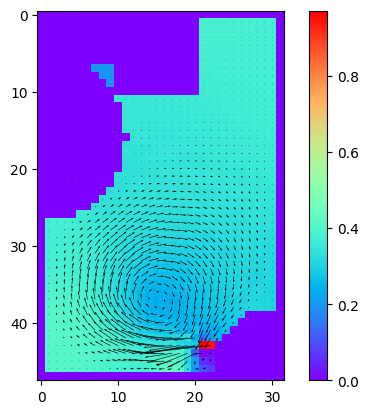

In [233]:
simulation.simulate(step = 10)
densityPlot = copy.copy(simulation.density)
densityPlot[walls.invertedBoundary] -= np.min(densityPlot[walls.invertedBoundary])
print(np.average(simulation.fluid))
print(simulation.getMomentum())

fig, ax = plt.subplots()
heatmap = ax.imshow(densityPlot, cmap = "rainbow", interpolation = "nearest")
quivermap = ax.quiver(simulation.xIndex, simulation.yIndex, simulation.momentumX, -simulation.momentumY)
fig.colorbar(heatmap)
# print(simulation.fluid)
plt.show()

In [218]:
velocityInlet = [VelocityBoundary(bestPos[0], bestPos[1], 1, )]
initCondition = np.ones((yResolution, xResolution, Simulation.latticeSize)) / 9
simulation = Simulation(
    yResolution, xResolution, initCondition, walls, velocityBoundaries=velocityInlet, pressureBoundaries=[]
)


TypeError: __init__() missing 1 required positional argument: 'direction'

0.07322398367085435
4.089237328432596


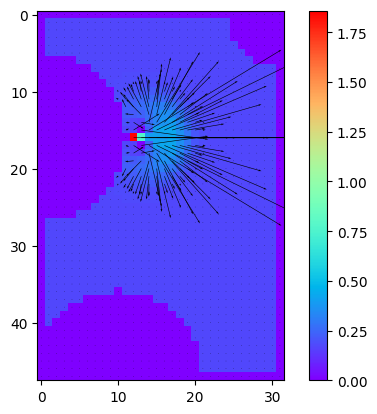

In [173]:
simulation.simulate(step = 10)
densityPlot = copy.copy(simulation.density)
densityPlot[walls.invertedBoundary] -= np.min(densityPlot[walls.invertedBoundary])
print(np.average(simulation.fluid))
print(simulation.getMomentum())

fig, ax = plt.subplots()
heatmap = ax.imshow(densityPlot, cmap = "rainbow", interpolation = "nearest")
quivermap = ax.quiver(simulation.xIndex, simulation.yIndex, simulation.momentumX, -simulation.momentumY)
fig.colorbar(heatmap)
# print(simulation.fluid)
plt.show()